In [ ]:
from subprocess import check_output
from speedml import Speedml
import warnings
warnings.filterwarnings('ignore')

class TitanicML:
    def __init__(self):
        self.sml = None

    def run(self):
        print("running")
        self.data()
        self.models()
        self.results()

    def data(self):
        print("preparing data")
        self.setup_speedml()
        self.prepare_data()

    def models(self):
        self.prepare_models()
        self.evaluate_models()
        self.predict_models()

    def results(self):
        self.save_results()
        self.write_results()

    def prepare_data(self):
        self.strip_outliers()
        self.create_family_size()
        self.create_title()
        self.create_deck()
        self.map_sex()
        self.map_embarked()
        self.impute_values()
        self.create_ticket_density()
        self.create_age_density()
        self.create_fare_density()
        print("data prepared")

    def setup_speedml(self):
        print("Setting up Speedml")
        self.sml = Speedml('../input/train.csv', '../input/test.csv', target='Survived', uid='PassengerId')

    def strip_outliers(self):
        print("Stripping Outliers")
        self.sml.feature.outliers('Fare', upper=99)
        self.sml.feature.outliers('SibSp', upper=99)

    def create_family_size(self):
        print("Merge Parch and SibSp into FamilySize")
        self.sml.feature.sum(new='FamilySize', a='Parch', b='SibSp')
        self.sml.feature.add('FamilySize', 1)
        self.sml.feature.drop('Parch')
        self.sml.feature.drop('SibSp')

    def create_title(self):
        print("extract Title from Name")
        self.sml.feature.extract(new='Title', a='Name', regex=r" ([A-Za-z]+)\.")
        self.sml.feature.replace(a='Title', match=['Lady', 'Countess', 'Dona', 'Mme'], new='Mrs')
        self.sml.feature.replace(a='Title', match=['Don', 'Sir', 'Jonkheer'], new='Mr')
        self.sml.feature.replace(a='Title', match=['Capt', 'Col', 'Dr', 'Major', 'Rev'], new='Crew')
        self.sml.feature.replace(a='Title', match=['Mlle','Ms'], new='Miss')
        self.sml.feature.mapping('Title', {'Miss': 1, 'Master': 2, 'Mrs': 3, 'Mr': 4, 'Crew': 5})
        self.sml.feature.fillna(a='Title', new=0)
        self.sml.feature.drop('Name')

    def map_sex(self):
        print("map sex")
        self.sml.feature.mapping('Sex', {'male': 0, 'female': 1})

    def create_deck(self):
        print("create deck and drop cabin")
        self.sml.feature.fillna(a='Cabin', new='Z')
        ## TODO: ^^ let's be smarter about this
        self.sml.feature.extract(new='Deck', a='Cabin', regex='([A-Z]){1}')
        self.sml.feature.labels(['Deck'])
        self.sml.feature.drop(['Cabin'])

    def map_embarked(self):
        print("map embarked")
        self.sml.feature.fillna(a='Embarked', new='Z')
        self.sml.feature.mapping('Embarked', {'S': 0, 'C': 1, 'Q': 2, 'Z': 3})

    def impute_values(self):
        print("IMPUTE BUT ONLY FOR NOW")
        self.sml.feature.impute()

    def create_ticket_density(self):
        print("drop ticket FOR NOW")
        #self.sml.feature.density('Ticket')
        self.sml.feature.drop('Ticket')
        ## TODO: ^^ let's figure out Deck using this and PClass

    def create_fare_density(self):
        print("FOR NOW add Fare densities")
        #self.sml.feature.density(['Fare'])

    def create_age_density(self):
        print("FOR NOW add Age densities")
        #self.sml.feature.density(['Age'])

    def prepare_models(self):
        print("prepare models")
        self.sml.model.data()
        self.set_model_parameters()

    def set_model_parameters(self):
        print("set model parameters")
        ret1 = self.refine_max_depth_and_min_child_weight()
        ret2 = self.refine_learning_rate_and_subsample(ret1)
        self.assign_tuned_variables(ret1, ret2)

    def refine_max_depth_and_min_child_weight(self):
        print("refine max depth and min child weight")
        select_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
        fixed_params = {'learning_rate': 0.1, 'subsample': 0.8,
                        'colsample_bytree': 0.8, 'seed':0,
                        'objective': 'binary:logistic'}
        ret = self.sml.xgb.hyper(select_params, fixed_params)
        return ret['params'][0]


    def refine_learning_rate_and_subsample(self, results):
        print("refine learning rate and subsamples with max_depth")
        select_params = {'learning_rate': [0.3, 0.1, 0.01], 'subsample': [0.7, 0.8, 0.9]}
        fixed_params = {'max_depth': results['max_depth'], 'min_child_weight': results['min_child_weight'],
                        'colsample_bytree': 0.8, 'seed': 0,
                        'objective': 'binary:logistic'}
        ret = self.sml.xgb.hyper(select_params, fixed_params)
        return ret['params'][0]

    def assign_tuned_variables(self, ret1, ret2):
        print("assign tuned variables")
        print("learning_rate: "+str(ret2['learning_rate']))
        print("subsample: "+str(ret2['subsample']))
        print("max_depth: "+str(ret1['max_depth']))
        print("min_child_weight: "+str(ret1['min_child_weight']))
        tuned_params = {'learning_rate': ret2['learning_rate'], 'subsample': ret2['subsample'],
                        'max_depth': ret1['max_depth'], 'min_child_weight': ret1['min_child_weight'],
                        'seed':0, 'colsample_bytree': 0.8,
                        'objective': 'binary:logistic'}
        self.sml.xgb.cv(tuned_params)
        tuned_params['n_estimators'] = self.sml.xgb.cv_results.shape[0] - 1
        self.sml.xgb.params(tuned_params)

    def evaluate_models(self):
        print("Show best models")
        self.sml.xgb.classifier()
        self.sml.model.evaluate()
        self.sml.plot.model_ranks()
        self.sml.model.ranks()

    def predict_models(self):
        print("predict and get accuracy")
        self.sml.xgb.fit()
        self.sml.xgb.predict()
        self.sml.xgb.feature_selection()
        self.sml.xgb.sample_accuracy()

    def save_results(self):
        print("save results when happy")
        self.sml.save_results(
            columns={'PassengerId': self.sml.uid,
                     'Survived': self.sml.xgb.predictions},
            file_path='output/titanic-speedml-{}.csv'.format(self.sml.slug()))
        self.sml.slug()

    def write_results(self):
        print(check_output(["ls", "../input"]).decode("utf8"))

In [2]:
titanic = TitanicML()
titanic.data()

preparing data
Setting up Speedml
Stripping Outliers
Merge Parch and SibSp into FamilySize
extract Title from Name
create deck and drop cabin
map sex
map embarked
IMPUTE BUT ONLY FOR NOW
drop ticket FOR NOW
FOR NOW add Age densities
FOR NOW add Fare densities
data prepared


In [ ]:
titanic.sml.eda()
titanic.sml.plot.correlate()

In [3]:
titanic.sml.model.data()
titanic.set_model_parameters()

'train_X: (891, 8) train_y: (891,) test_X: (418, 8)'

set model parameters
refine max depth and min child weight
refine learning rate and subsamples with max_depth
assign tuned variables
learning_rate: 0.3
subsample: 0.7
max_depth: 3
min_child_weight: 1


Show best models


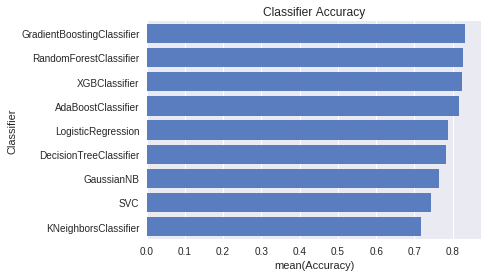

In [4]:
titanic.evaluate_models()

In [5]:
titanic.predict_models()

predict and get accuracy
Accuracy: 78.360000%
Thresh=0.019, n=8, Accuracy: 78.36%
Thresh=0.040, n=7, Accuracy: 78.36%
Thresh=0.077, n=6, Accuracy: 78.36%
Thresh=0.081, n=5, Accuracy: 77.99%
Thresh=0.089, n=4, Accuracy: 70.52%
Thresh=0.098, n=3, Accuracy: 69.78%
Thresh=0.245, n=2, Accuracy: 69.40%
Thresh=0.352, n=1, Accuracy: 69.40%
